![NERSC Logo](https://noirlab.edu/public/media/archives/logos/original_trans/logo087.png)
## National Energy Research Scientific Computing Center

# Introduction to High Performance Computing Bootcamp - Argonne National Laboratory August 2025
# Module 2: Top 500 Supercomputers Analysis

## 🎯 Learning Outcomes

By the end of this module, you will be able to:

- Explore and visualize the performance and energy efficiency of the world's top supercomputers.
- Use real-world data from the TOP500 list to analyze trends in ranking, power consumption, and regional distribution.
- Create interactive plots to compare performance metrics and derive insights from global supercomputing trends.


## Introduction
In this module, we will focus on understanding and analyzing the trends in the Top500 and Green500 supercomputing lists. These lists provide valuable insights into the evolution of supercomputing technology and its efficiency.

![Top 500](https://www.top500.org/static//images/Top500_logo.png)

### Top500
The Top500 project ranks and details the 500 most powerful non-distributed computer systems in the world. The project was started in 1993 and publishes an updated list of the supercomputers twice a year. The first of these updates always coincides with the International Supercomputing Conference in June, and the second is presented at the ACM/IEEE Supercomputing Conference in November. The project aims to provide a reliable basis for tracking and detecting trends in high-performance computing.

### Green500
The Green500 list ranks the top 500 supercomputers in the world by energy efficiency. The list is released twice a year, in conjunction with the Top500 list. The aim of the Green500 is to provide a ranking of the most energy-efficient supercomputers in the world and to serve as a complementary view to the Top500 list. The Green500 list makes it clear that performance is not the only consideration when ranking supercomputers, as power efficiency has become an increasingly important metric.

#### Getting Started
We will explore and analyze the data from these lists, looking at trends and making comparisons between the supercomputers. This will provide a deeper understanding of the advancements in supercomputing technology and the increasing importance of energy efficiency.

### Data Analysis Environment Setup
<img src=https://www.scalecomputing.com/images/SEO/high-performance-computing-use-cases-diagram.png width="500">
Before we begin exploring the TOP500 dataset, we need to set up a small toolkit that will make our analysis smooth, flexible, and reproducible. In this cell, we load essential Python libraries and define helper functions that will prepare the data for visualization and computation:

- **`pandas`** — our main data handling library, used to load, inspect, and transform the dataset.
- **`matplotlib`** — the plotting library we’ll use to create clear, publication-quality graphics.
- **`re`** (regular expressions) — used for text pattern matching and cleaning column names.

We also configure default plotting settings so that all charts are easy to read in a training environment.  
These settings ensure consistent figure sizes and enable gridlines for better visual interpretation.

Finally, we define three utility functions that help adapt our code to different versions of the TOP500 dataset:

1. **`normalize`** — Standardizes column names by lowercasing, removing special characters, and collapsing spaces.  
   *Why?* Different datasets sometimes label columns slightly differently (e.g., `"Rmax [TFlop/s]"` vs `"RMax(TFlops)"`).  
   This function makes them comparable.

2. **`find_col`** — Searches the dataset’s column headers for a match based on keywords, so we can locate columns even if the exact name changes.  
   This makes the notebook more robust and less “hard-coded.”

3. **`coerce_numeric`** — Safely converts values stored as text (e.g., `"1,234.5"`) into numbers so we can sort, filter, and plot them correctly.  
   It automatically handles commas, spaces, and non-breaking spaces.

This setup step is a **foundation**: everything we do later—ranking supercomputers, calculating energy efficiency, or analyzing geographic distribution—depends on having clean, consistent data to work with.


In [5]:
# ---- Setup (Matplotlib + Pandas) ----
import pandas as pd
import matplotlib.pyplot as plt
import re

# Plot defaults (single-plot style)
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

def normalize(s: str) -> str:
    """Lowercase, remove brackets/parentheses, collapse spaces/underscores."""
    s = str(s)
    s = s.lower().replace("\u202f", " ")
    s = re.sub(r"[()\[\]]", "", s)
    s = re.sub(r"[_\s]+", " ", s).strip()
    return s

def find_col(cols, must_include):
    """Find first column whose normalized name contains all tokens in must_include."""
    ncols = {c: normalize(c) for c in cols}
    for c, n in ncols.items():
        if all(tok in n for tok in must_include):
            return c
    return None

def coerce_numeric(series):
    """Turn strings like '1,234.5' or '1 234.5' into floats; keep NaN if not parseable."""
    return pd.to_numeric(
        series.astype(str)
              .str.replace("\u202f", "", regex=False)
              .str.replace(",", "", regex=False)
              .str.replace(" ", "", regex=False),
        errors="coerce"
    )


### Loading and Preparing the TOP500 Dataset

With our analysis environment ready, the next step is to load the TOP500 dataset and prepare it for analysis.  
In this cell, we:

1. **Load the CSV file** — The dataset path is set to `data/TOP500_202506.csv`, but you can change this if your file is in a different location or has a different name.

2. **Detect important columns dynamically** — Using the `find_col` helper from our setup step, we identify the key columns we’ll need for our analysis:
   - **System Name** (`name_col`)  
   - **Site ID** (as a fallback if name is missing)  
   - **Country** (`country_col`)  
   - **Vendor/Manufacturer** (`vendor_col`)  
   - **Performance metrics**: `Rmax` and `Rpeak`  
   - **Power consumption** (`power_col`)  
   - **Accelerator core counts** and **total core counts**

   This dynamic detection makes the notebook resilient to small changes in column naming conventions across different releases of the dataset.

3. **Fill missing names** — If a system name is missing, we replace it with the site ID so every row has a meaningful identifier.

4. **Convert numeric columns** — Many numeric fields in CSVs are stored as strings with commas or spaces (e.g., `"1,234.5"`).  
   We use `coerce_numeric` to clean and convert these columns into actual numbers so we can sort, filter, and plot them correctly.

Finally, we **print the detected column mappings** so you can verify that the notebook found the correct fields, and display the first three rows of the cleaned dataset.

This step ensures that downstream analyses—like ranking systems by performance or comparing power efficiency—will work reliably regardless of formatting quirks in the CSV file.


In [6]:
# ---- Load Data ----
DATA_PATH = "data/TOP500_202506.csv"  # Adjust if needed
df = pd.read_csv(DATA_PATH)

# Identify key columns robustly (works across minor header variations)
name_col    = find_col(df.columns, ["name"]) or find_col(df.columns, ["system", "name"]) or find_col(df.columns, ["system"])
site_col    = find_col(df.columns, ["site", "id"])  # fallback
country_col = find_col(df.columns, ["country"])
vendor_col  = find_col(df.columns, ["vendor"]) or find_col(df.columns, ["manufacturer"])
rmax_col    = find_col(df.columns, ["rmax", "flop"]) or find_col(df.columns, ["r max", "flop"])
rpeak_col   = find_col(df.columns, ["rpeak", "flop"]) or find_col(df.columns, ["r peak", "flop"])
power_col   = find_col(df.columns, ["power", "kw"]) or find_col(df.columns, ["power"])  # sometimes just Power
accel_cores_col = find_col(df.columns, ["accelerator", "cores"]) or find_col(df.columns, ["gpu", "cores"])
total_cores_col = find_col(df.columns, ["cores"])  # generic fall-back

# Fill names from site if missing
if name_col is None and site_col is not None:
    name_col = site_col
elif name_col is not None and site_col is not None:
    df[name_col] = df[name_col].fillna(df[site_col])

# Coerce numerics where present
for col in [rmax_col, rpeak_col, power_col, accel_cores_col, total_cores_col]:
    if col in df.columns:
        df[col] = coerce_numeric(df[col])

print("Detected columns ->",
      "\n  name_col:", name_col,
      "\n  country_col:", country_col,
      "\n  vendor_col:", vendor_col,
      "\n  rmax_col:", rmax_col,
      "\n  rpeak_col:", rpeak_col,
      "\n  power_col:", power_col,
      "\n  accel_cores_col:", accel_cores_col,
      "\n  total_cores_col:", total_cores_col)

df.head(3)


Detected columns -> 
  name_col: Name 
  country_col: Country 
  vendor_col: Manufacturer 
  rmax_col: Rmax [TFlop/s] 
  rpeak_col: Rpeak [TFlop/s] 
  power_col: Power (kW) 
  accel_cores_col: Accelerator/Co-Processor Cores 
  total_cores_col: Total Cores


,Rank,Previous Rank,First Appearance,First Rank,Name,Computer,Site,Manufacturer,Country,Year,...,Accelerator/Co-Processor,Cores per Socket,Processor Generation,System Model,System Family,Interconnect Family,Interconnect,Continent,Site ID,System ID
0,1,1.0,64,1,El Capitan,"HPE Cray EX255a, AMD 4th Gen EPYC 24C 1.8GHz, ...",DOE/NNSA/LLNL,HPE,United States,2024,...,AMD Instinct MI300A,24,AMD Zen-4 (Genoa),HPE Cray EX255a,HPE Cray EX,Gigabit Ethernet,Slingshot-11,North America,"49,763",180307
1,2,2.0,59,1,Frontier,"HPE Cray EX235a, AMD Optimized 3rd Generation ...",DOE/SC/Oak Ridge National Laboratory,HPE,United States,2021,...,AMD Instinct MI250X,64,AMD Zen-3 (Milan),HPE Cray EX235a,HPE Cray EX,Gigabit Ethernet,Slingshot-11,North America,"48,553",180047
2,3,3.0,62,2,Aurora,"HPE Cray EX - Intel Exascale Compute Blade, Xe...",DOE/SC/Argonne National Laboratory,Intel,United States,2023,...,Intel Data Center GPU Max,52,Intel Xeon Max,HPE Cray EX - Intel Exascale Compute Blade,HPE Cray EX - Intel Exascale Compute Blade,Gigabit Ethernet,Slingshot-11,North America,"47,347",180183


## Exercise 2 - Energy Efficiency
Objectives:
1) Compute performance per watt (use Rmax / Power).
2) Identify the top 10 most efficient systems.
3) Make a scatter plot of Rmax vs Power, and discuss outliers.

High performance is valuable, but in DOE HPC systems, **performance per watt** is equally critical due to facility power limits, cost, and sustainability goals.  
In this step, we evaluate how efficiently each supercomputer converts electrical power into computational performance.

**What this code does:**

1. **Check for power data** — If the dataset lacks a power consumption column, the analysis is skipped.  
   This prevents errors and makes the workflow adaptable to datasets with varying levels of detail.

2. **Prepare a working copy** — We duplicate the dataset into `df_eff` so the original `df` remains unchanged for future steps.

3. **Filter valid rows** — Systems must have a non-missing, non-zero power value to be included. This avoids division errors and misleading results.

4. **Calculate efficiency** —  
   - We create a new column `efficiency_perf_per_kw` as:
     \[
     \text{Efficiency} = \frac{\text{Rmax}}{\text{Power (kW)}}
     \]
   - This metric represents *measured performance per kilowatt*.

5. **Identify the leaders** — We sort systems by this efficiency metric and display the **Top 10** most efficient systems, including their:
   - Name
   - Rmax
   - Power consumption
   - Efficiency value

6. **Visualize the relationship** —  
   - A scatter plot of `Rmax` (x-axis) vs `Power (kW)` (y-axis) shows the performance–power tradeoff.  
   - Clusters can reveal architectural patterns, and outliers may indicate exceptionally efficient or inefficient systems.

**Why this matters in the DOE HPC Bootcamp context:**  
DOE facilities operate under strict energy budgets, often in the tens of megawatts.  
By focusing on *performance per watt*, we connect raw HPC capability to real-world constraints in system design, procurement, and operation. This metric also foreshadows our upcoming analysis on **accelerator usage** and **vendor architectures**, which often directly influence efficiency.



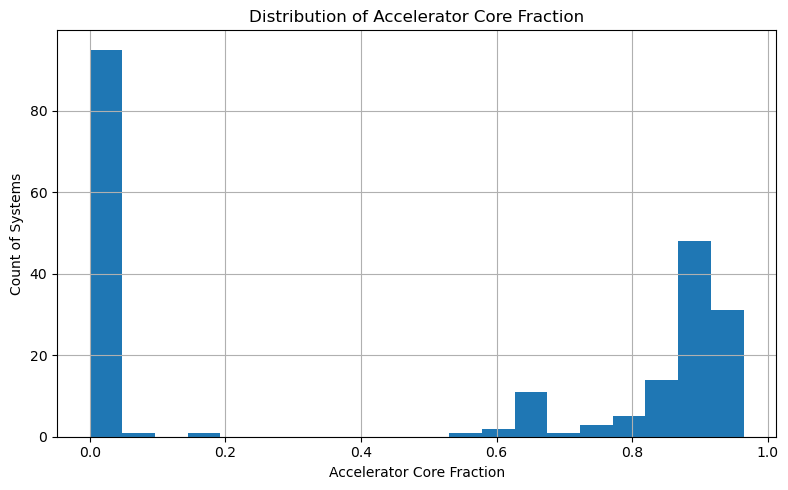

Avg efficiency (accelerated):   35.9
Avg efficiency (non-accelerated): 5.32


In [7]:
# --- Your Work: Accelerator fraction & comparison ---
if accel_cores_col and total_cores_col and power_col:
    tmp = df.copy()
    tmp = tmp[(tmp[total_cores_col].notna()) & (tmp[total_cores_col] > 0)]
    tmp["accel_frac"] = (tmp[accel_cores_col].fillna(0)) / tmp[total_cores_col]

    # Reuse efficiency metric if available
    tmp = tmp[(tmp[power_col].notna()) & (tmp[power_col] > 0)]
    tmp["efficiency_perf_per_kw"] = tmp[rmax_col] / tmp[power_col]

    # Histogram of accelerator fraction
    plt.figure()
    plt.hist(tmp["accel_frac"].dropna(), bins=20)
    plt.xlabel("Accelerator Core Fraction")
    plt.ylabel("Count of Systems")
    plt.title("Distribution of Accelerator Core Fraction")
    plt.tight_layout()
    plt.show()

    # Compare efficiency by acceleration
    is_accel = tmp["accel_frac"] > 0
    eff_accel = tmp.loc[is_accel, "efficiency_perf_per_kw"].mean()
    eff_noacc = tmp.loc[~is_accel, "efficiency_perf_per_kw"].mean()
    print(f"Avg efficiency (accelerated):   {eff_accel:.3g}")
    print(f"Avg efficiency (non-accelerated): {eff_noacc:.3g}")
else:
    print("Needed columns for accelerator analysis not found; skipping.")


### Exercise 3 – Accelerator (GPU) Usage and Its Impact on Efficiency
Objectives:
1) Estimate the fraction of accelerator cores for each system.
2) Compare average efficiency between accelerated vs non-accelerated systems.
3) Plot a histogram of accelerator-core fractions.



Modern HPC systems increasingly rely on **accelerators**—such as GPUs or specialized co-processors—to boost performance and improve energy efficiency.  
In this step, we explore how prevalent accelerators are in the TOP500 list and examine their relationship to performance-per-watt.

**What this code does:**

1. **Check for required data** — We proceed only if the dataset contains:
   - Total core counts
   - Accelerator (GPU) core counts
   - Power consumption values

2. **Calculate accelerator fraction** —  
   For each system, we compute:
   \[
   \text{Accelerator Fraction} = \frac{\text{Accelerator Cores}}{\text{Total Cores}}
   \]
   This tells us what proportion of a system’s compute cores are accelerators.

3. **Recompute efficiency metric** —  
   Using the filtered dataset, we ensure `efficiency_perf_per_kw` is available so we can compare systems with and without accelerators on a fair basis.

4. **Visualize accelerator prevalence** —  
   A histogram shows the distribution of accelerator fractions across systems:
   - **0.0** means no accelerators (pure CPU)
   - **1.0** means all cores are accelerators (rare)
   - Intermediate values indicate hybrid designs

5. **Compare average efficiency** —  
   We split systems into two groups:
   - **Accelerated** (fraction > 0)
   - **Non-accelerated** (fraction = 0)  
   Then compute and print the mean efficiency for each group.

**Why this matters in the DOE HPC Bootcamp context:**  
Accelerators have been central to recent performance gains in HPC, including DOE’s exascale systems.  
This exercise highlights:
- How common accelerators are in the current TOP500.
- Whether accelerator-based designs consistently achieve higher performance-per-watt.
- How system architecture choices influence both raw performance and operational efficiency.


Top 10 by Rmax per kW:


,Name,Rmax [TFlop/s],Power (kW),efficiency_perf_per_kw
0,Adastra 2,2529.0,36.60,69.098361
1,JEDI,4504.0,67.31,66.914277
2,Henri,2882.0,44.07,65.395961
3,Portage,24100.0,371.48,64.875633
4,Hunter,31680.0,490.00,64.653061
5,Isambard-AI phase 1,7417.0,117.08,63.349846
6,HoreKa-Teal,3123.0,49.60,62.963710
7,rzAdams,24380.0,388.20,62.802679
8,Frontier TDS,19200.0,308.68,62.200337
9,Viper-GPU,31096.0,499.98,62.194488


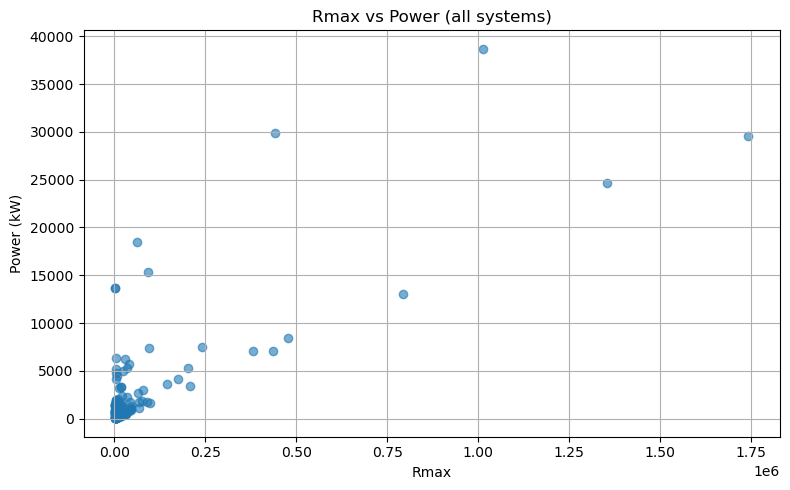

In [8]:
# --- Your Work: Efficiency metric ---
if power_col is None:
    print("No power column detected; skipping efficiency analysis.")
else:
    eff_col = "efficiency_perf_per_kw"
    df_eff = df.copy()
    # Avoid division by zero
    df_eff = df_eff[(df_eff[power_col].notna()) & (df_eff[power_col] > 0)]
    df_eff[eff_col] = df_eff[rmax_col] / df_eff[power_col]

    # Top 10 efficient systems
    top_eff = df_eff.sort_values(eff_col, ascending=False).head(10)
    print("Top 10 by Rmax per kW:")
    try:
        from IPython.display import display
        display(top_eff[[name_col, rmax_col, power_col, eff_col]].reset_index(drop=True))
    except Exception:
        print(top_eff[[name_col, rmax_col, power_col, eff_col]].reset_index(drop=True))

    # Scatter plot: Rmax vs Power
    plt.figure()
    plt.scatter(df_eff[rmax_col], df_eff[power_col], alpha=0.6)
    plt.xlabel("Rmax")
    plt.ylabel("Power (kW)")
    plt.title("Rmax vs Power (all systems)")
    plt.tight_layout()
    plt.show()


### Exercise 4 – Geographic Distribution of HPC Systems

Objectives:
1) Count systems per country and plot the top N countries.
2) Compare each country's total Rmax share of the list.
3) Discuss which regions lead, and why (policy, funding, industry?).

HPC is a global endeavor, and the location of systems reflects each country’s investment in scientific research, industry, and national security.  
In this step, we examine where the top-performing systems are located and how total performance is distributed geographically.

**What this code does:**

1. **Check for country data** — If the dataset includes a country column, we can analyze geographic patterns; otherwise, this section is skipped.

2. **Count systems per country** —  
   - We group the dataset by country.
   - Count the number of systems in each country.
   - Sort in descending order.
   - Select the **top 12** countries for visualization.

3. **Visualize system counts** —  
   A horizontal bar chart shows the number of systems in the top 12 countries, with the largest counts at the top.

4. **Total Rmax per country** —  
   If `Rmax` data is available:
   - We sum the `Rmax` values for each country.
   - Sort and select the **top 12**.
   - Plot another horizontal bar chart to show total measured performance by country.

**Why this matters in the DOE HPC Bootcamp context:**  
Geographic distribution analysis highlights:
- Which nations have the largest HPC infrastructures.
- How performance is concentrated or distributed globally.
- The potential for international collaboration or competition in scientific computing.

For DOE participants, this provides a broader context for where U.S. systems fit into the global HPC landscape, both in terms of **number of systems** and **aggregate performance**.



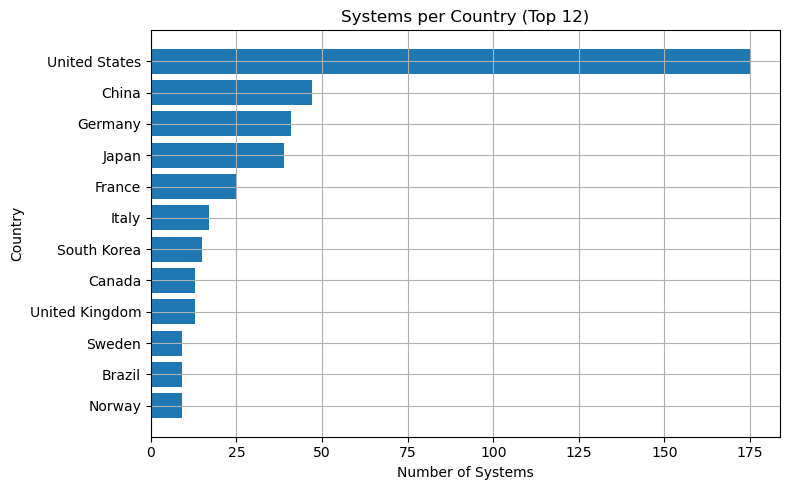

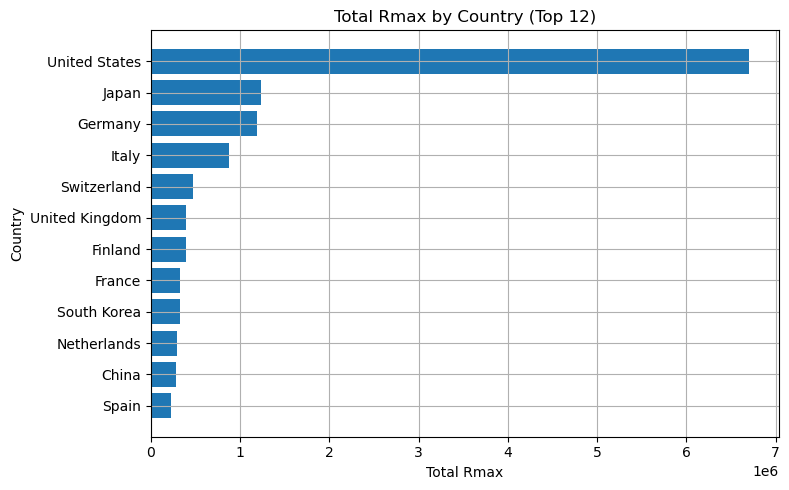

In [9]:
# --- Your Work: Country distribution ---
if country_col is not None:
    count_by_country = df.groupby(country_col, dropna=False).size().sort_values(ascending=False)
    topn = count_by_country.head(12)

    plt.figure()
    plt.barh(topn.index.astype(str), topn.values)
    plt.gca().invert_yaxis()
    plt.xlabel("Number of Systems")
    plt.ylabel("Country")
    plt.title("Systems per Country (Top 12)")
    plt.tight_layout()
    plt.show()

    if rmax_col is not None:
        rmax_by_country = df.groupby(country_col, dropna=False)[rmax_col].sum().sort_values(ascending=False).head(12)
        plt.figure()
        plt.barh(rmax_by_country.index.astype(str), rmax_by_country.values)
        plt.gca().invert_yaxis()
        plt.xlabel("Total Rmax")
        plt.ylabel("Country")
        plt.title("Total Rmax by Country (Top 12)")
        plt.tight_layout()
        plt.show()
else:
    print("No country column detected; skipping geographic distribution.")


              Name  Rmax [TFlop/s]  Power (kW)
0       El Capitan       1742000.0    29580.98
1         Frontier       1353000.0    24607.00
2           Aurora       1012000.0    38698.36
3  JUPITER Booster        793400.0    13088.23
4            Eagle        561200.0         NaN


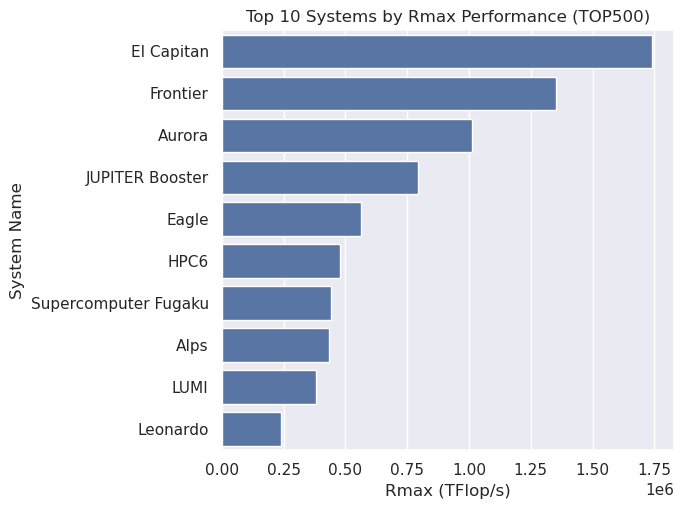

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# --- helpers ---
def normalize(s: str) -> str:
    """Lowercase, remove brackets/parentheses, collapse spaces/underscores."""
    s = s.lower()
    s = s.replace("\u202f", " ")  # thin space
    s = re.sub(r"[()\[\]]", "", s)
    s = re.sub(r"[_\s]+", " ", s).strip()
    return s

def find_col(cols, must_include):
    """Find first column whose normalized name contains all tokens in must_include."""
    ncols = {c: normalize(c) for c in cols}
    for c, n in ncols.items():
        if all(tok in n for tok in must_include):
            return c
    return None

def coerce_numeric(series):
    """Turn strings like '1,234.5' or '1 234.5' into floats; keep NaN if not parseable."""
    return pd.to_numeric(
        series.astype(str)
              .str.replace("\u202f", "", regex=False)  # thin NBSP
              .str.replace(",", "", regex=False)
              .str.replace(" ", "", regex=False),
        errors="coerce"
    )

# --- config / style ---
scale = 1.75
sns.set(rc={'figure.figsize': (4 * scale, 3 * scale)})

# --- load ---
data_path = "data/TOP500_202506.csv"
data = pd.read_csv(data_path)

# --- identify key columns robustly ---
name_col   = find_col(data.columns, ["name"]) or find_col(data.columns, ["system", "name"])
site_col   = find_col(data.columns, ["site", "id"])  # fallback for empty names
rmax_col   = (find_col(data.columns, ["rmax", "flop"]) or
              find_col(data.columns, ["r max", "flop"]))
power_col  = (find_col(data.columns, ["power", "kw"]) or
              find_col(data.columns, ["power"]))  # sometimes just "Power"

if name_col is None and site_col is None:
    raise KeyError("Couldn't find a Name or Site ID-like column. Columns are:\n" + ", ".join(data.columns))

# --- cleaning ---
df = data.copy()
# fill names from site if name missing
if name_col is None:
    name_col = site_col
elif site_col is not None:
    df[name_col].fillna(df[site_col], inplace=True)

# make numeric
if rmax_col is None:
    raise KeyError("Couldn't find an Rmax column. Looked for headers containing 'rmax' and 'flop'. "
                   f"Available columns: {list(data.columns)}")
df[rmax_col] = coerce_numeric(df[rmax_col])

if power_col in df.columns:
    df[power_col] = coerce_numeric(df[power_col])

# drop rows with no Rmax
df = df.dropna(subset=[rmax_col])

# quick peek
print(df[[name_col, rmax_col] + ([power_col] if power_col in df.columns else [])].head(5))

# --- choose top 10 by Rmax ---
top10 = df.sort_values(rmax_col, ascending=False).head(10)

# detect units to label axis nicely
rmax_label = rmax_col
norm_rmax = normalize(rmax_col)
if "pflop" in norm_rmax:
    x_label = "Rmax (PFlop/s)"
elif "tflop" in norm_rmax:
    x_label = "Rmax (TFlop/s)"
else:
    x_label = "Rmax"

# --- plot ---
sns.barplot(data=top10, x=rmax_col, y=name_col)
plt.xlabel(x_label)
plt.ylabel("System Name")
plt.title("Top 10 Systems by Rmax Performance (TOP500)")
plt.tight_layout()
plt.show()


In [ ]:
### Exercise 4 – Geographic Distribution of HPC Systems

Objectives:
1) Count systems per country and plot the top N countries.
2) Compare each country's total Rmax share of the list.
3) Discuss which regions lead, and why (policy, funding, industry?).

HPC is a global endeavor, and the location of systems reflects each country’s investment in scientific research, industry, and national security.  
In this step, we examine where the top-performing systems are located and how total performance is distributed geographically.

**What this code does:**

1. **Check for country data** — If the dataset includes a country column, we can analyze geographic patterns; otherwise, this section is skipped.

2. **Count systems per country** —  
   - We group the dataset by country.
   - Count the number of systems in each country.
   - Sort in descending order.
   - Select the **top 12** countries for visualization.

3. **Visualize system counts** —  
   A horizontal bar chart shows the number of systems in the top 12 countries, with the largest counts at the top.

4. **Total Rmax per country** —  
   If `Rmax` data is available:
   - We sum the `Rmax` values for each country.
   - Sort and select the **top 12**.
   - Plot another horizontal bar chart to show total measured performance by country.

**Why this matters in the DOE HPC Bootcamp context:**  
Geographic distribution analysis highlights:
- Which nations have the largest HPC infrastructures.
- How performance is concentrated or distributed globally.
- The potential for international collaboration or competition in scientific computing.

For DOE participants, this provides a broader context for where U.S. systems fit into the global HPC landscape, both in terms of **number of systems** and **aggregate performance**.



### Exercise 5 – Vendor-Level Performance and Efficiency

Vendors play a critical role in the HPC ecosystem, influencing everything from system architecture to power efficiency.  
In this step, we examine how different vendors compare in terms of **average system performance** and **average performance-per-watt**.

**What this code does:**

1. **Check for vendor data** — We proceed only if the dataset contains a column for the system’s vendor or manufacturer.

2. **Prepare a working copy** —  
   If power consumption data is available:
   - Filter out rows with missing or zero power values.
   - Compute `efficiency_perf_per_kw` for each system.

3. **Aggregate by vendor** —  
   Using `groupby`, we calculate:
   - **Average Rmax** per vendor.
   - **Average efficiency** (Rmax per kW) if power data is available.

4. **Rank and display results** —  
   - Show the **Top 10 vendors** ranked by average Rmax.
   - If efficiency data is available, show the **Top 10 vendors** ranked by average performance-per-watt.

5. **Visualize vendor efficiency** —  
   - Create a horizontal bar chart of the top vendors by efficiency.
   - This makes it easier to spot leaders in energy-efficient design.

**Why this matters in the DOE HPC Bootcamp context:**  
Vendor-level analysis provides insight into:
- Which companies are producing the highest-performing systems.
- How different architectures and design philosophies impact efficiency.
- Potential procurement considerations for DOE facilities, where performance must be balanced with operational cost and energy constraints.


### Exercise 5 – Vendor-Level Performance and Efficiency

Vendors play a critical role in the HPC ecosystem, influencing everything from system architecture to power efficiency.  
In this step, we examine how different vendors compare in terms of **average system performance** and **average performance-per-watt**.

**What this code does:**

1. **Check for vendor data** — We proceed only if the dataset contains a column for the system’s vendor or manufacturer.

2. **Prepare a working copy** —  
   If power consumption data is available:
   - Filter out rows with missing or zero power values.
   - Compute `efficiency_perf_per_kw` for each system.

3. **Aggregate by vendor** —  
   Using `groupby`, we calculate:
   - **Average Rmax** per vendor.
   - **Average efficiency** (Rmax per kW) if power data is available.

4. **Rank and display results** —  
   - Show the **Top 10 vendors** ranked by average Rmax.
   - If efficiency data is available, show the **Top 10 vendors** ranked by average performance-per-watt.

5. **Visualize vendor efficiency** —  
   - Create a horizontal bar chart of the top vendors by efficiency.
   - This makes it easier to spot leaders in energy-efficient design.

**Why this matters in the DOE HPC Bootcamp context:**  
Vendor-level analysis provides insight into:
- Which companies are producing the highest-performing systems.
- How different architectures and design philosophies impact efficiency.
- Potential procurement considerations for DOE facilities, where performance must be balanced with operational cost and energy constraints.


,Rmax [TFlop/s],efficiency_perf_per_kw
Manufacturer,,
Intel,1.012000e+06,26.150979
Nebius AI,1.244700e+05,36.723128
IBM / NVIDIA / Mellanox,9.464000e+04,12.723372
NRCPC,9.301459e+04,6.051304
HPE,7.987891e+04,27.677867
NUDT,6.144450e+04,3.324559
Fujitsu,4.990043e+04,17.935454
ASUSTeK,4.582000e+04,42.976261
EVIDEN,4.041491e+04,19.315827


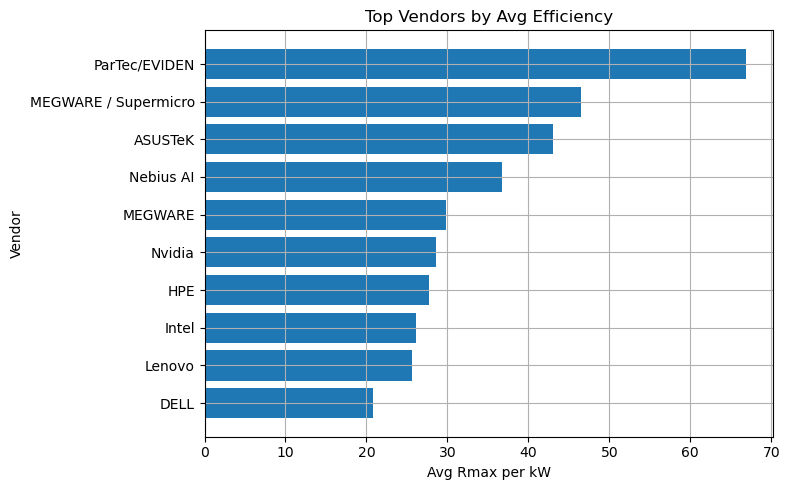

In [11]:
# --- Your Work: Vendor-level metrics ---
if vendor_col is not None:
    work = df.copy()
    # Compute efficiency if possible
    if power_col is not None:
        work = work[(work[power_col].notna()) & (work[power_col] > 0)]
        work["efficiency_perf_per_kw"] = work[rmax_col] / work[power_col]

    agg_dict = {rmax_col: "mean"}
    if "efficiency_perf_per_kw" in work.columns:
        agg_dict["efficiency_perf_per_kw"] = "mean"

    vendor_stats = work.groupby(vendor_col).agg(agg_dict).sort_values(rmax_col, ascending=False)
    try:
        from IPython.display import display
        display(vendor_stats.head(10))
    except Exception:
        print(vendor_stats.head(10))

    # Plot by efficiency if available
    if "efficiency_perf_per_kw" in vendor_stats.columns:
        top_eff = vendor_stats.sort_values("efficiency_perf_per_kw", ascending=False).head(10)
        plt.figure()
        plt.barh(top_eff.index.astype(str), top_eff["efficiency_perf_per_kw"].values)
        plt.gca().invert_yaxis()
        plt.xlabel("Avg Rmax per kW")
        plt.ylabel("Vendor")
        plt.title("Top Vendors by Avg Efficiency")
        plt.tight_layout()
        plt.show()
else:
    print("No vendor/manufacturer column detected; skipping vendor analysis.")


---

## **Module 2 – Top 500 Discussion Prompts**

These questions are designed to help you synthesize insights from your analysis and connect them to broader DOE HPC considerations.  
You may discuss them in your Bootcamp group or submit written responses as part of your exercise deliverable.

---

### 1. **Which systems or vendors deliver the best performance per watt?**
- Identify specific systems and their `Rmax per kW` values.
- Note any patterns in architectures (e.g., CPU-only vs GPU-accelerated, vendor design choices, cooling strategies if available).
- Discuss whether the same vendors dominate **both** raw performance (`Rmax`) and energy efficiency, or if leaders differ between these metrics.
- Consider why certain vendors might excel in efficiency (e.g., use of accelerators, custom interconnects, power-aware designs).

---

### 2. **Do countries with more systems also dominate total Rmax?**
- Compare the **Top N countries by number of systems** with the **Top N by total `Rmax`**.
- Identify any countries with *fewer systems but disproportionately high total performance*.
- Consider what this says about investment strategies (e.g., many smaller systems vs fewer but more powerful systems).
- Reflect on what this might mean for global HPC competitiveness.

---

### 3. **How strongly does accelerator fraction correlate with efficiency in your results?**
- Examine whether systems with a higher proportion of accelerator cores have **higher average performance-per-watt**.
- Consider exceptions—are there highly efficient CPU-only systems? Why might they exist?
- Discuss whether accelerators seem to offer consistent efficiency gains, or if benefits vary by vendor or architecture.

---

### 4. **If you had budget and power constraints, what procurement strategy would you propose for a new DOE system?**
- Assume you have:
  - A fixed **budget** for hardware acquisition.
  - A fixed **power budget** for system operation.
- Recommend a system architecture (e.g., CPU-heavy, GPU-heavy, hybrid).
- Justify your vendor and technology choice based on:
  - Performance-per-watt
  - Reliability of vendor performance in the dataset
  - Country/vendor track record in delivering top-tier systems
- Discuss trade-offs between peak performance, efficiency, and system scalability.

---

### 5. **Document your assumptions and validation methods**
- Record any assumptions you made about:
  - Column names (e.g., detecting `Rmax` vs `Rpeak`, identifying power columns)
  - Units (e.g., whether `Power` is in kW or MW, whether `Rmax` is in TFlop/s or PFlop/s)
- Describe how you validated these assumptions (e.g., checking a few known systems against public TOP500.org entries).
- Include any data cleaning steps you performed (e.g., handling missing values, normalizing names).


---

### 🌱 Extension Activity – Analyze the Green500 List

In the main portion of Module 2, you explored the **Top500** list using performance, efficiency, accelerator usage, and vendor/country breakdowns.  
Now, apply the **same analysis guidelines** to the **Green500** list—the companion ranking that orders systems by **energy efficiency** (performance-per-watt).

**Your task:**
1. **Download the latest Green500 dataset** from [https://www.top500.org/green500](https://www.top500.org/green500).
2. Load the data into your notebook.
3. Follow the same analysis flow used for the Top500 list:
   - Column detection and data cleaning
   - Top systems by efficiency and performance
   - Accelerator usage analysis
   - Geographic and vendor-level metrics

**Analysis questions to explore:**
1. **Overlap:** Which systems appear in both the Top10 of the Green500 and the Top500? Do they excel in both raw performance and efficiency?
2. **Architecture trends:** Are highly efficient systems more likely to use accelerators than the general HPC population?
3. **Geographic efficiency leaders:** Which countries dominate the Green500, and how does this compare to their standing in the Top500?
4. **Vendor efficiency leadership:** Are the most efficient vendors the same ones leading in raw performance, or does the leaderboard shift when focusing on efficiency?

**Goal:**  
Identify key differences between the performance-focused Top500 and the efficiency-focused Green500, and reflect on what this means for **DOE system design** where *both* performance and power constraints must be considered.

💡 *Tip:* Some of the top Green500 entries may be smaller experimental clusters. Consider whether their design choices could scale to DOE-sized systems while maintaining efficiency.

---


## Conclusion

In this module, we explored the **Top500** supercomputer dataset, applied data cleaning techniques, and created visualizations to uncover patterns in performance, efficiency, architecture, and global distribution.  
By dynamically detecting columns and handling variations in the dataset, you built an analysis pipeline that is both **reusable** and **adaptable** to future dataset updates.

You have now:
- Identified **top-performing systems** by both measured and theoretical performance.
- Evaluated **energy efficiency** and understood why performance-per-watt is critical for DOE facilities.
- Investigated **accelerator adoption** and its relationship to system efficiency.
- Analyzed **geographic and vendor trends** in the HPC ecosystem.

These skills and workflows form the foundation for deeper HPC data analysis, whether you’re:
- Tracking **efficiency leaders** in the Green500.
- Monitoring **vendor technology shifts** over time.
- Exploring **historical trends** in HPC system design.

**Next steps:**
- Apply the same methodology to the **Green500** dataset to compare efficiency rankings against raw performance standings.
- Consider extending your analysis to multiple years of Top500 data to study *long-term trends* in performance growth, energy usage, and architectural evolution.

Remember: The real power of this work lies not only in finding “the fastest” or “the most efficient” systems, but in connecting the data to **strategic decisions** for system procurement, research planning, and sustainable HPC operations.

---
